In [1149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

### Load Dictionary .npy

In [1150]:
dictionary = np.load('dictionary.npy', allow_pickle=True).item()
print(type(dictionary))
volunteers = sorted(dictionary.keys())
print('Volunteers:',volunteers)

<class 'dict'>
Volunteers: ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31']


### Signals access example

In [1151]:
print(dictionary['S01'].keys())
print(dictionary['S01']['Lower'].keys())
print(dictionary['S01']['Lower']['Task1'].keys())
print(dictionary['S01']['Lower']['Task1']['X'].keys())

dict_keys(['Lower', 'Upper'])
dict_keys(['Task1', 'Task2', 'Task3'])
dict_keys(['X', 'Y'])
dict_keys(['Left', 'Rest', 'Right'])


In [1152]:
df_info = pd.read_excel('C:/Users/Usuario/Documents/GitHub/Data_base_processing/Database_Info.xlsx')
upper_dominant = (df_info["Upper Dominant Laterality"]).tolist()
lower_dominant = (df_info["Lower Dominant Laterality"]).tolist()
print('Upper dominant=',upper_dominant)
print('Lower dominant=',lower_dominant)

Upper dominant= ['Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left']
Lower dominant= ['Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left']


# PSD - Feet

In [1153]:
feet_channels = ['CZ', 'C4', 'C3', 'FZ', 'PZ']

trials, channels, samples = dictionary['S01']['Lower']['Task1']['X']['Rest'].shape
print(f"Trials={trials}|Channels={channels}|Samples={samples}")

volunteer = 2

if volunteer < 10:
    ini = 'S0'
else:
    ini = 'S'

X = dictionary[ini+str(volunteer)]['Lower']['Task1']['X']
Y = dictionary[ini+str(volunteer)]['Lower']['Task1']['Y']

Trials=80|Channels=5|Samples=1000


### Signal channel mean

In [1154]:
def graph_mean_feet(trials, feet_channels,title):
    signals_class = { 'CZ': [], 'C4': [], 'C3': [], 'FZ': [], 'PZ': [] }
    
    # Construir signals_class
    for trial in range(len(trials)):
        signals_class['CZ'].append(trials[trial][0])
        signals_class['C4'].append(trials[trial][1])
        signals_class['C3'].append(trials[trial][2])
        signals_class['FZ'].append(trials[trial][3])
        signals_class['PZ'].append(trials[trial][4])

    # Crear la figura y los ejes
    fig, axes = plt.subplots(1, 5, figsize=(16, 4))

    # Graficar señales
    for idx, channel in enumerate(signals_class.keys()):
        mean = np.mean(signals_class[channel], axis=0)
        std = np.std(signals_class[channel], axis=0)
        
        axes[idx].plot(mean, label='Mean')
        axes[idx].fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)
        axes[idx].set_title(feet_channels[idx])
        axes[idx].legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



(40, 5, 1000)


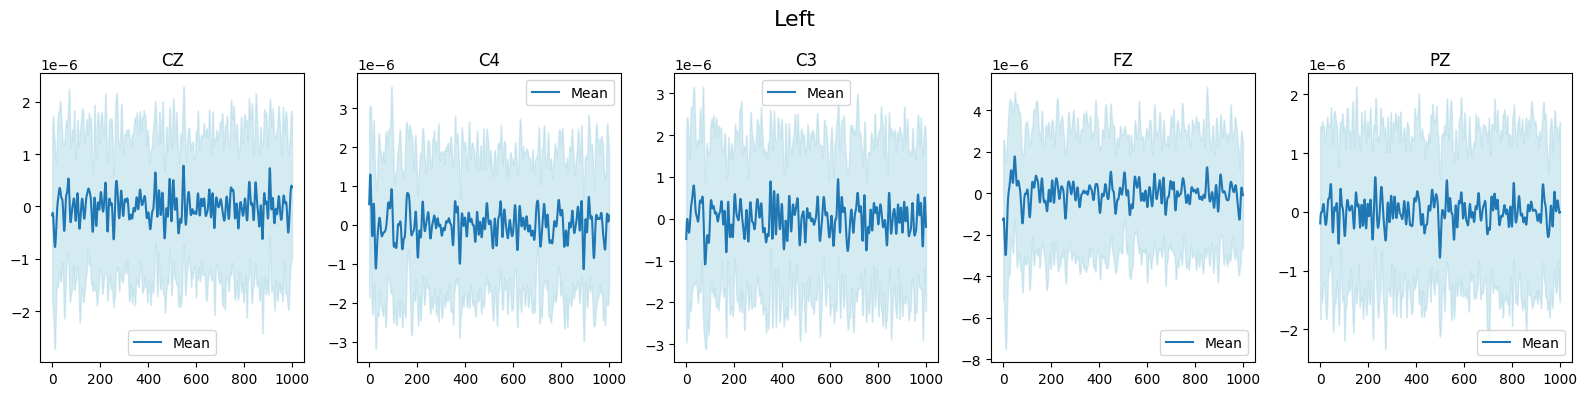

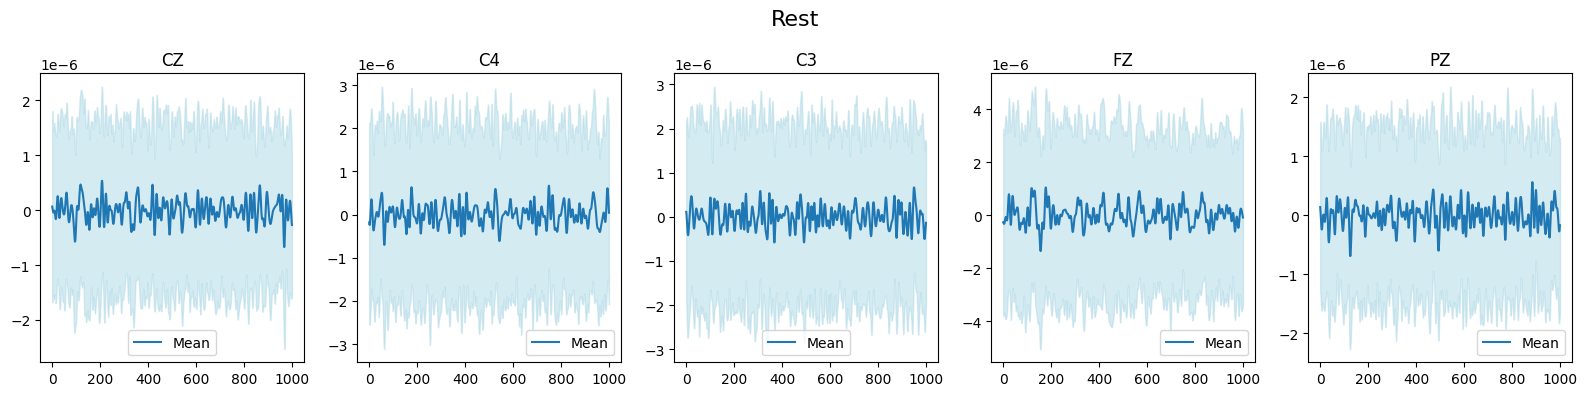

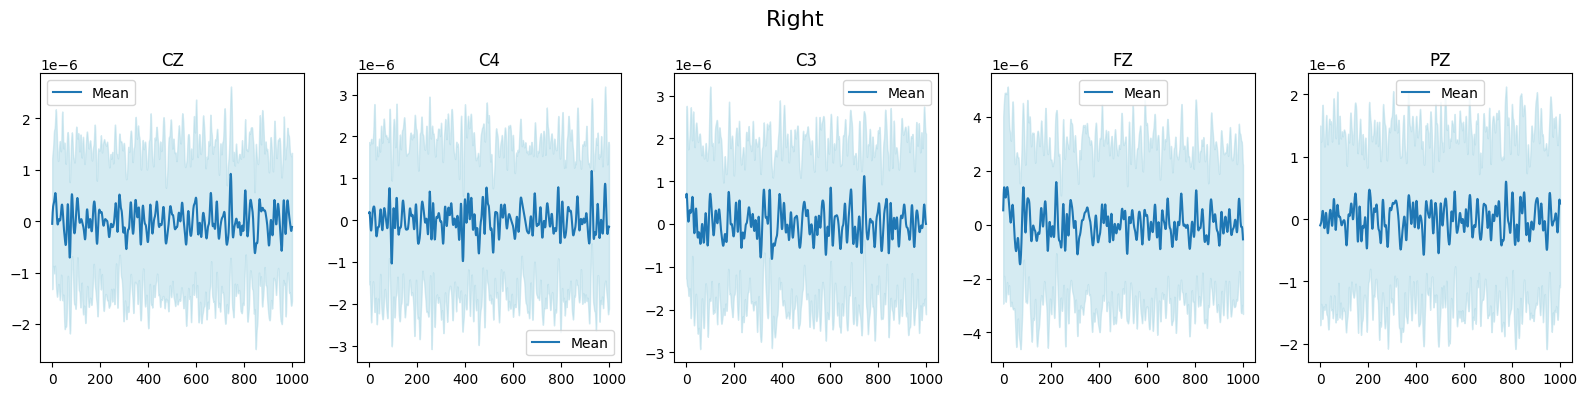

In [1155]:
print((X['Left'].shape))
graph_mean_feet(X['Left'],feet_channels,'Left')
graph_mean_feet(X['Rest'],feet_channels,'Rest')
graph_mean_feet(X['Right'],feet_channels,'Right')
   

### Laplacian filter

In [1156]:
def laplacian_filter(senal):
  samples, channels, trials = senal.shape
  laplacian = np.empty((samples, trials), np.float64) 

  for i in range(trials):
      for k in range(samples):
          sample_sum = 0
          for j in range(channels - 1):
              sample_sum += senal[k, j, i] 
          laplacian[k, i] = senal[k, channels - 1, i] - (sample_sum / (channels - 1))  
  return laplacian

In [1157]:
laplace_left = laplacian_filter(X['Left'])
trials, samples = laplace_left.shape
print(f"Left Trials={trials}|Samples={samples}")
laplace_right = laplacian_filter(X['Right'])
trials, samples = laplace_right.shape
print(f"Right Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Left Trials=40|Samples=1000
Right Trials=40|Samples=1000
Rest Trials=80|Samples=1000


In [1158]:
# Graficar señales
def graph_signals(signals, title, x_axis=None):
    fig = plt.figure(figsize=(16, 4))
    mean = np.mean(signals, axis=0)
    std = np.std(signals, axis=0)

    if x_axis is None:
        x_axis = range(len(mean))  # Por defecto, usa 0 al número de muestras
    
    
    plt.plot(mean, label='Mean')
    plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)
    plt.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

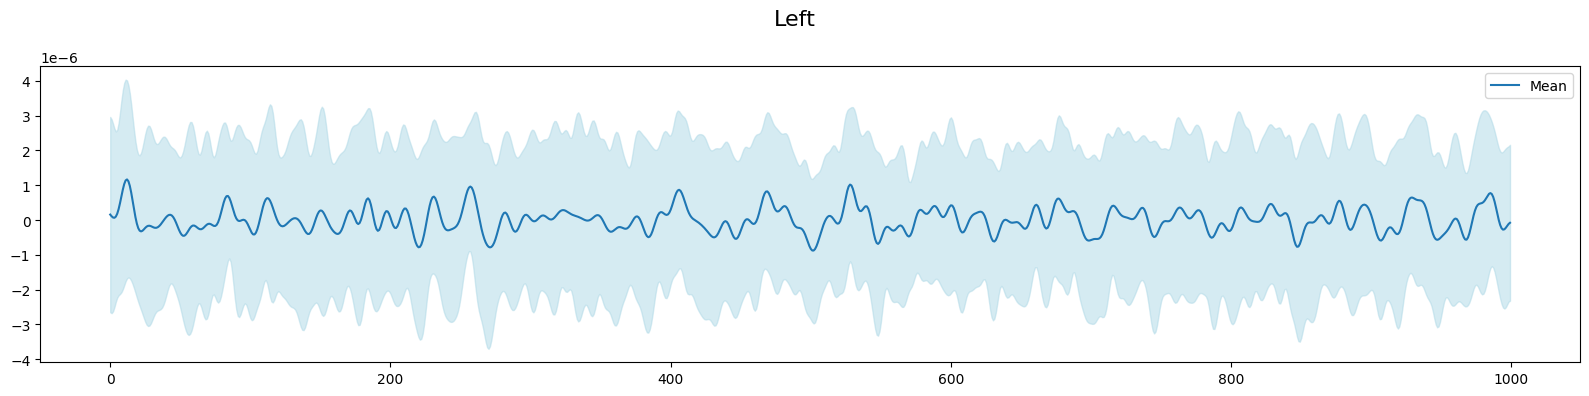

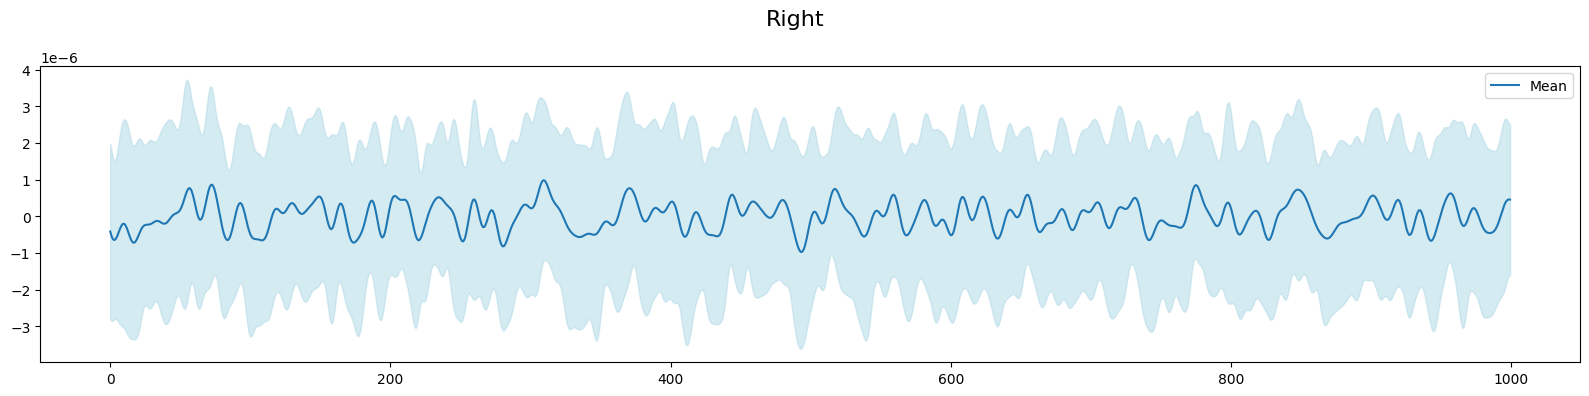

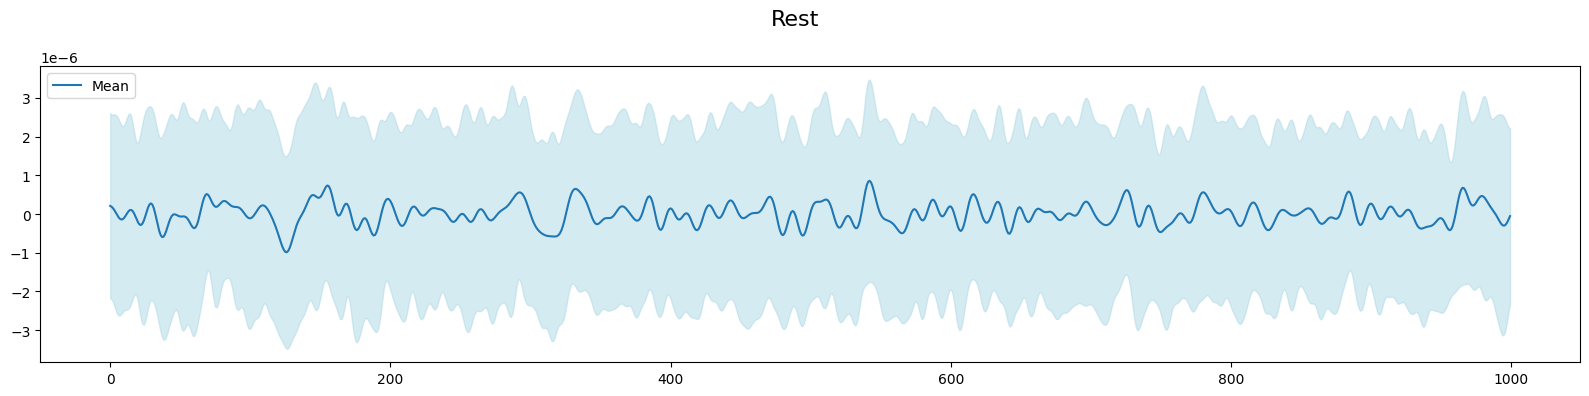

In [1159]:
graph_signals(laplace_left,'Left')
graph_signals(laplace_right,'Right')
graph_signals(laplace_rest,'Rest')

<Figure size 1600x400 with 0 Axes>

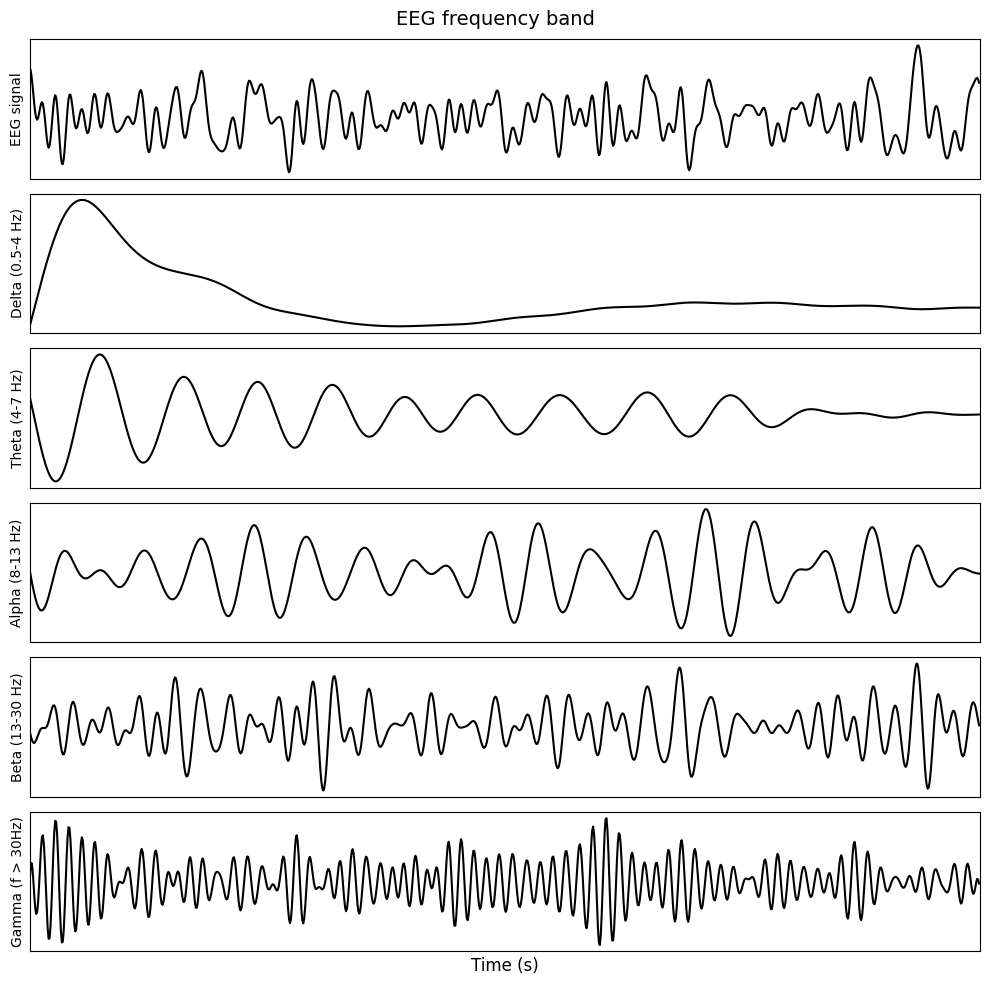

In [1160]:
# Graficar señales libro
def graph_signals_art(signals, title, x_axis=None):
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt
    fig = plt.figure(figsize=(16, 4))
    eeg_signal = signals[0]

    # Función para diseñar un filtro pasa-banda
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyq = 0.5 * fs  # Frecuencia de Nyquist
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    # Función para aplicar el filtro a la señal
    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        return filtfilt(b, a, data)

    # Parámetros
    fs = 500  # Frecuencia de muestreo en Hz
    t = np.arange(0, 2, 1/fs)  # Vector de tiempo de 10 segundos

    # Simular una señal EEG (o usar una real)
    np.random.seed(42)
    #eeg_signal = 0.5 * np.random.randn(len(t))  # Ruido blanco como EEG sintético
   


    # Filtrar en cada banda
    delta = bandpass_filter(-eeg_signal , 0.5, 4, fs)
    theta = bandpass_filter(eeg_signal, 4, 7, fs)
    alpha = bandpass_filter(eeg_signal, 8, 12, fs)
    beta = bandpass_filter(eeg_signal, 12, 30, fs)
    gamma = bandpass_filter(eeg_signal, 30, 100, fs)

    # Graficar las señales filtradas
    fig, axes = plt.subplots(6, 1, figsize=(10, 10), sharex=True)
    bands = [("EEG signal", eeg_signal),
            ("Delta (0.5-4 Hz)", delta),
            ("Theta (4-7 Hz)", theta),
            ("Alpha (8-13 Hz)", alpha),
            ("Beta (13-30 Hz)", beta),
            ("Gamma (f > 30Hz)", gamma)]

    for ax, (label, signal) in zip(axes, bands):
        ax.plot(t, signal, 'k')
        ax.set_ylabel(label, fontsize=10)
        ax.set_xlim(0, 2)  # Mostrar solo los primeros 2 segundos
        ax.set_yticks([])
        ax.set_xticks([]) 
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)

    axes[-1].set_xlabel("Time (s)", fontsize=12)
    plt.suptitle("EEG frequency band", fontsize=14)
    plt.tight_layout()
    plt.savefig("grafica_eeg.svg", format="svg", bbox_inches="tight")
    plt.show()

graph_signals_art(laplace_left,'Left')

### PSD

In [1161]:
print(laplace_left.shape)

def PSD(signals, fs=500, nperseg=500, overlap=250):
    trials, samples = signals.shape
    psd_values = []
    for trial in range(trials):
        freqs, psd = signal.welch(signals[trial], fs, nperseg=nperseg, noverlap=overlap, window='hamming', scaling='density')
        psd_values.append(psd)
    
    psd_values = np.array(psd_values)
    return psd_values, freqs

(40, 1000)


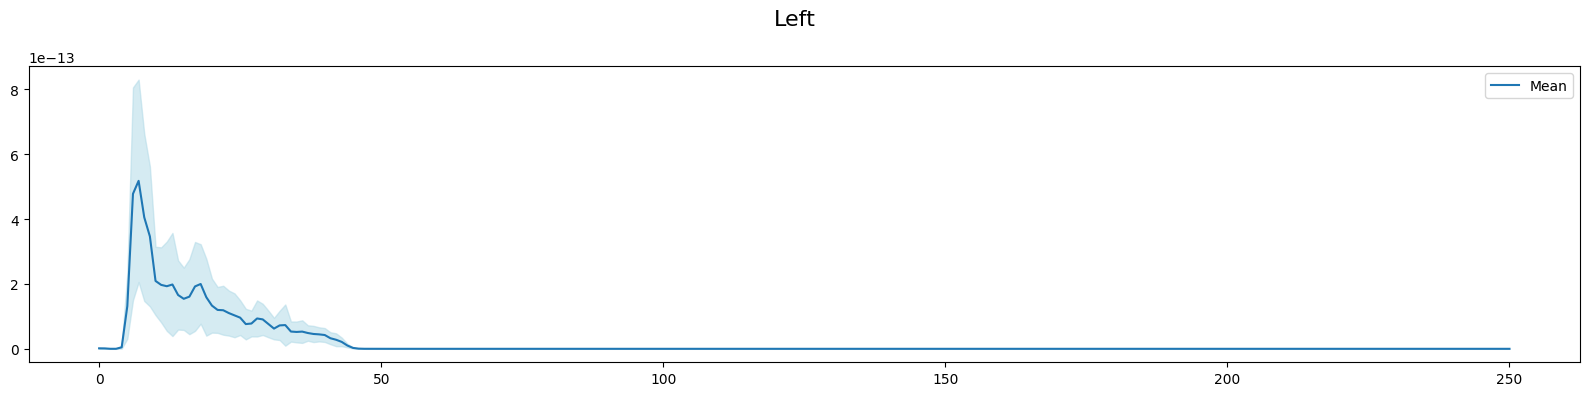

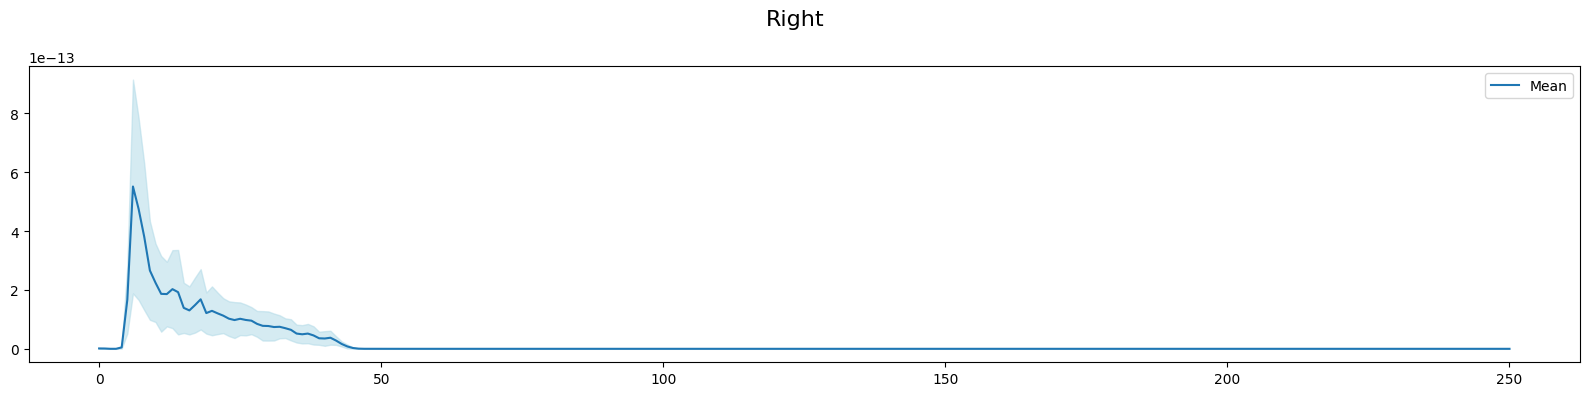

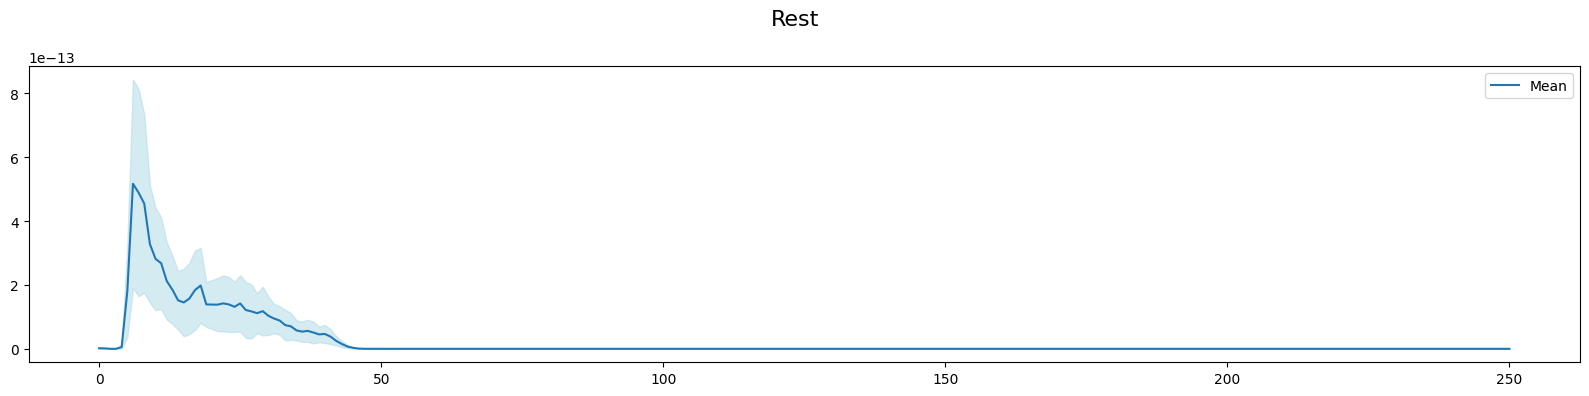

In [1162]:
PSD_left, freq = PSD(laplace_left)
PSD_right, freq = PSD(laplace_right)
PSD_rest, freq = PSD(laplace_rest)

graph_signals(PSD_left,'Left',freq)
graph_signals(PSD_right,'Right',freq)
graph_signals(PSD_rest,'Rest',freq)


In [1163]:
def PSD_rithms(signals, fs=500, nperseg=500, overlap=250, lfreq=8, hfreq=30):
    trials, samples = signals.shape
    psd_values = []
    for trial in range(trials):
        freqs, psd = signal.welch(signals[trial], fs, nperseg=nperseg, noverlap=overlap, window='hamming', scaling='density')
        # Filtrar valores de PSD en el rango de 8 a 30 Hz
        indices = np.where((freqs >= lfreq) & (freqs <= hfreq))
        filtered_psd = psd[indices]  # Valores PSD en el rango deseado
        
        psd_values.append(filtered_psd)
    
    psd_values = np.array(psd_values)
    filtered_freqs = freqs[indices]
    return psd_values, filtered_freqs

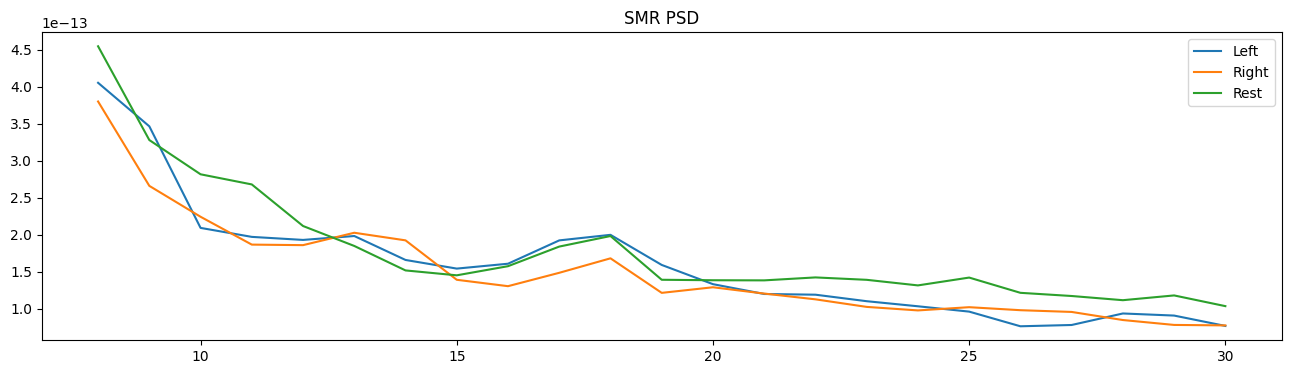

In [1164]:
PSD_left, freq = PSD_rithms(laplace_left)
PSD_right, freq = PSD_rithms(laplace_right)
PSD_rest, freq = PSD_rithms(laplace_rest)

plt.figure(figsize=(16, 4))
plt.plot(freq, np.mean(PSD_left, axis=0), label='Left')
plt.plot(freq, np.mean(PSD_right, axis=0), label='Right')
plt.plot(freq, np.mean(PSD_rest, axis=0), label='Rest')
plt.legend()
plt.title('SMR PSD')
plt.show()



### Clasificador

In [1165]:
if lower_dominant[volunteer-1] == 'Right':
    index = np.random.choice(PSD_rest.shape[0], 40, replace=False) 
    selection = PSD_rest[index]
    X = np.concatenate((PSD_right, selection), axis=0)
else:
    index = np.random.choice(PSD_rest.shape[0], 40, replace=False) 
    selection = PSD_rest[index]
    X = np.concatenate((PSD_left, selection), axis=0)

y = np.concatenate((np.ones(40),np.zeros(40)), axis=0)

print('Tamaño X:', X.shape, 'Tamaño y:', y.shape)

Tamaño X: (80, 23) Tamaño y: (80,)


In [1166]:
# Normalización
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

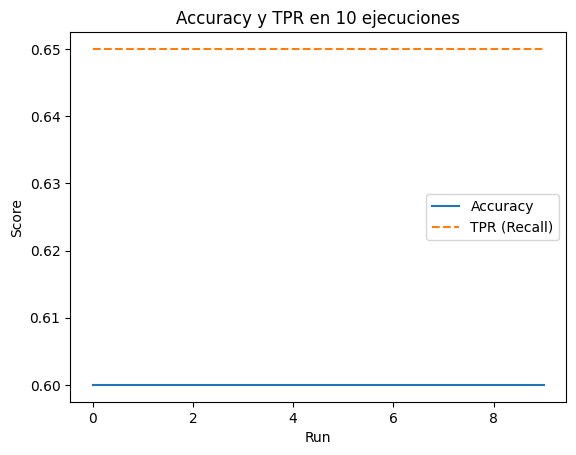

In [1167]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

scoring = {'accuracy': 'accuracy', 'tpr': 'recall'}
acc = []
TPR = []
for run in range(10):
    acc_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    tpr_scores = cross_val_score(clf, X, y, cv=5, scoring='recall')

    acc.append(np.mean(acc_scores))
    TPR.append(np.mean(tpr_scores))

plt.figure()
plt.plot(acc, label='Accuracy')
plt.plot(TPR, label='TPR (Recall)', linestyle='dashed')
plt.legend()
plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Accuracy y TPR en 10 ejecuciones')
plt.show()

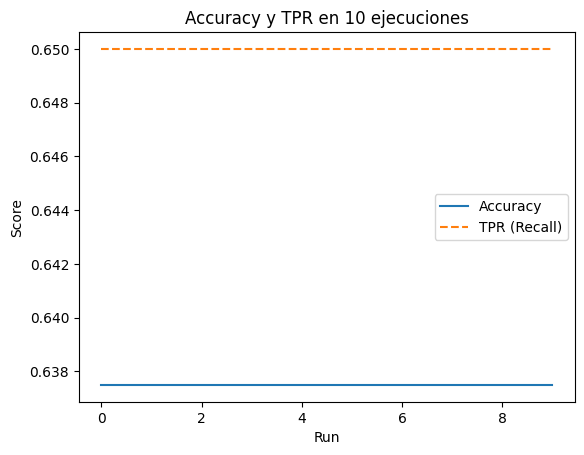

In [1168]:
from sklearn.svm import SVC


clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

scoring = {'accuracy': 'accuracy', 'tpr': 'recall'}
acc = []
TPR = []
for run in range(10):
    acc_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    tpr_scores = cross_val_score(clf, X, y, cv=5, scoring='recall')

    acc.append(np.mean(acc_scores))
    TPR.append(np.mean(tpr_scores))

plt.figure()
plt.plot(acc, label='Accuracy')
plt.plot(TPR, label='TPR (Recall)', linestyle='dashed')
plt.legend()
plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Accuracy y TPR en 10 ejecuciones')
plt.show()

[[5 3]
 [2 6]]
[[5 3]
 [4 4]]
[[5 3]
 [4 4]]
[[4 4]
 [2 6]]
[[5 3]
 [3 5]]


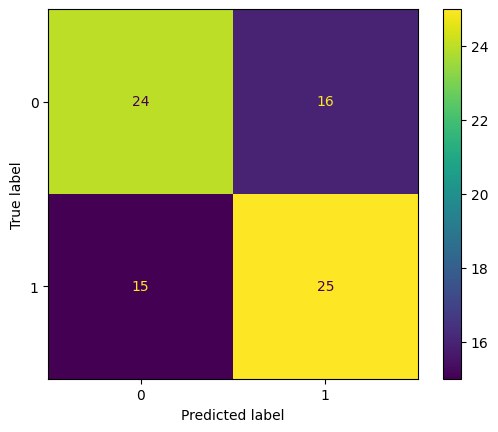

Accuracy promedio: 0.6125
Precision promedio: 0.6152
Recall promedio: 0.6125
F1-score promedio: 0.6104


In [1169]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []
num_clases = len(np.unique(y))  
sum_conf_matrix = np.zeros((num_clases, num_clases)) 

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Train
    lda.fit(X_train, y_train)
    #Test
    y_pred = lda.predict(X_test)

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Guardar métricas
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)
    print(conf_matrix)
    sum_conf_matrix += conf_matrix


# Calcular medias
mean_acc = np.mean(accuracies)
mean_prec = np.mean(precisions)
mean_rec = np.mean(recalls)
mean_f1 = np.mean(f1_scores)


# Results
cm_display = ConfusionMatrixDisplay(confusion_matrix = sum_conf_matrix)
cm_display.plot()
plt.show()

print(f'Accuracy promedio: {mean_acc:.4f}')
print(f'Precision promedio: {mean_prec:.4f}')
print(f'Recall promedio: {mean_rec:.4f}')
print(f'F1-score promedio: {mean_f1:.4f}')

    

### Validation

#### Tarea 2

In [1170]:
X_T2 = dictionary[ini+str(volunteer)]['Lower']['Task2']['X']
Y_T2 = dictionary[ini+str(volunteer)]['Lower']['Task2']['Y']

(30, 5, 1000)


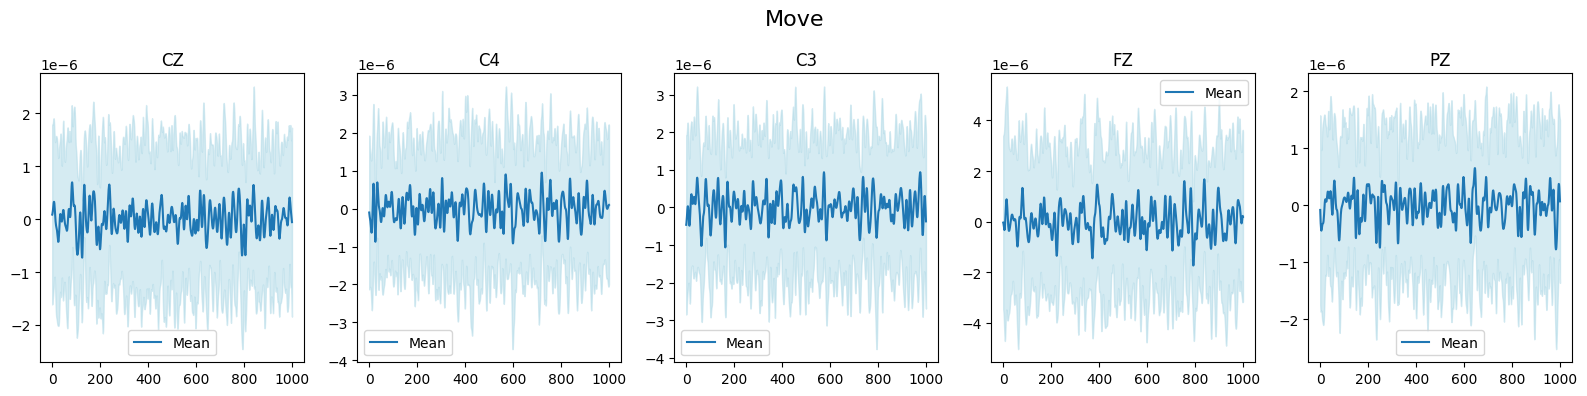

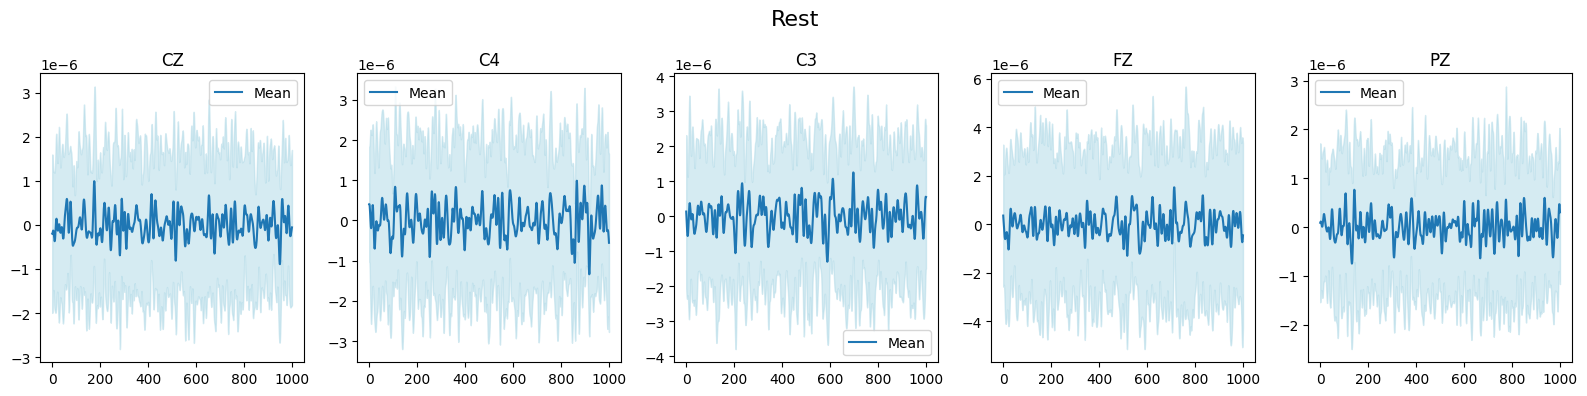

In [1171]:
print((X_T2['Move'].shape))
graph_mean_feet(X_T2['Move'],feet_channels,'Move')
graph_mean_feet(X_T2['Rest'],feet_channels,'Rest')

In [1172]:
laplace_move = laplacian_filter(X_T2['Move'])
trials, samples = laplace_move.shape
print(f"Move Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X_T2['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Move Trials=30|Samples=1000
Rest Trials=30|Samples=1000


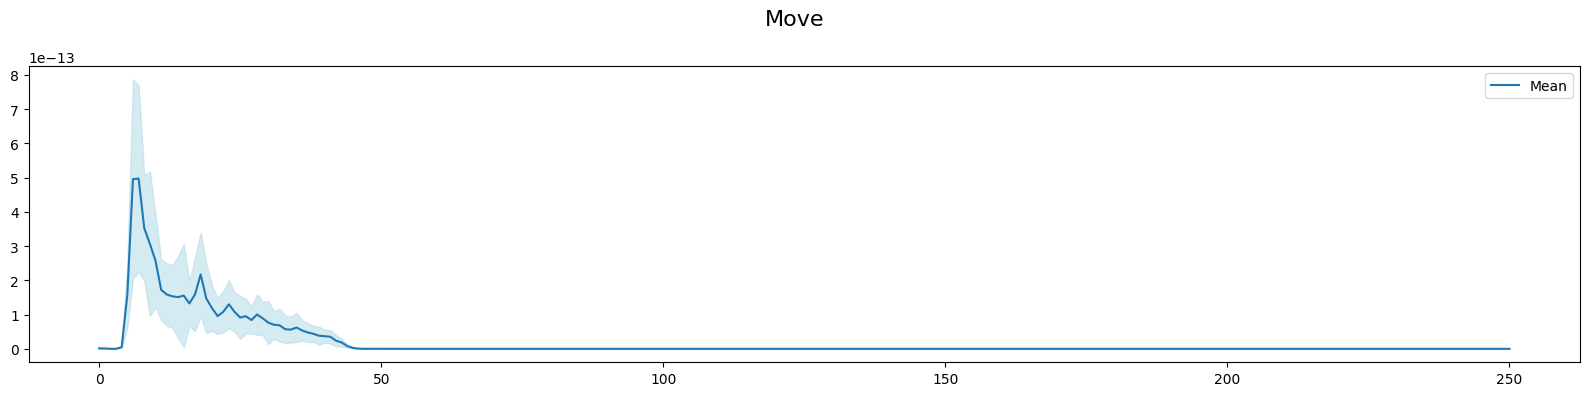

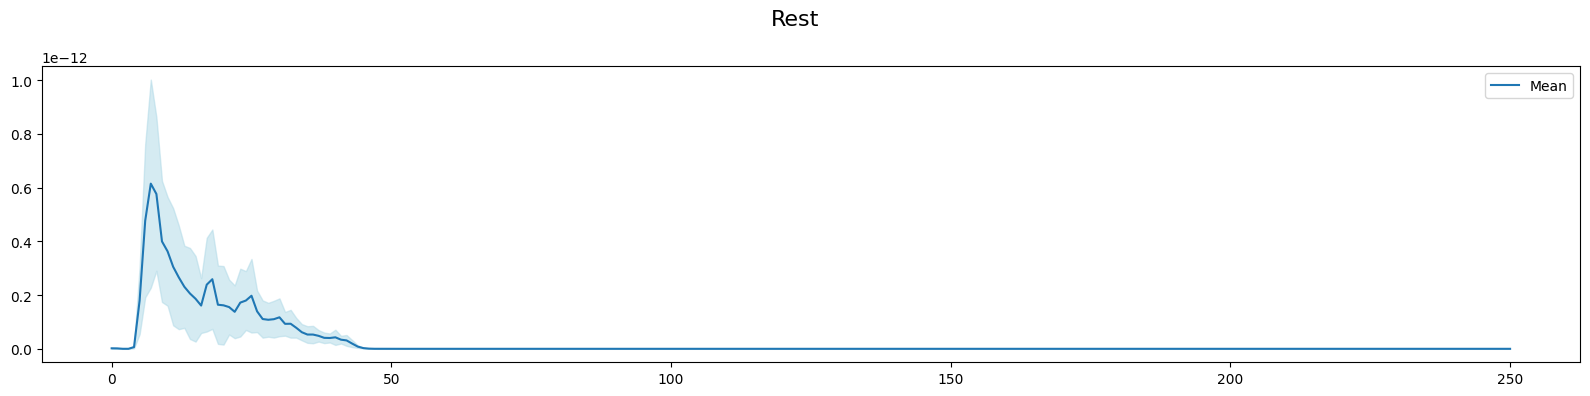

In [1173]:
PSD_move, freq = PSD(laplace_move)
PSD_rest, freq = PSD(laplace_rest)

graph_signals(PSD_move,'Move',freq)
graph_signals(PSD_rest,'Rest',freq)

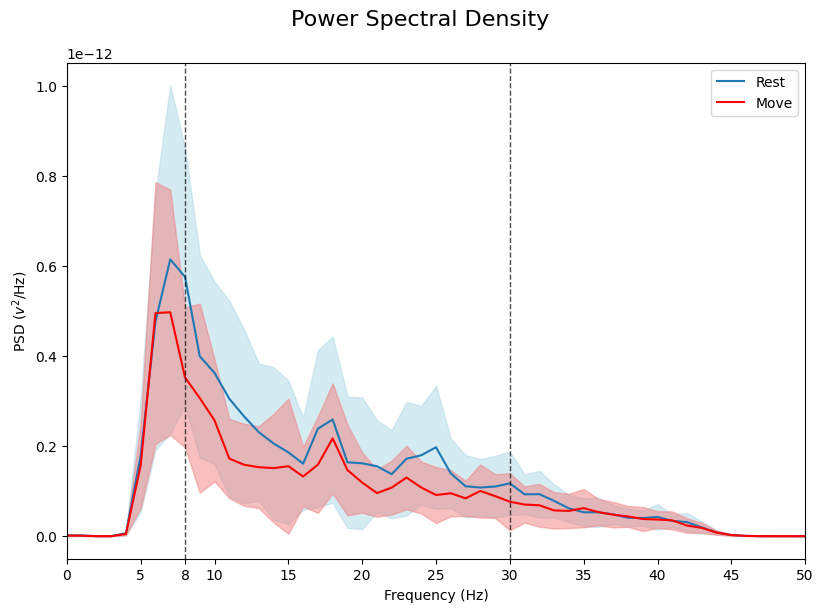

In [1174]:
# Grafica en conjunto libro
plt.figure(figsize=(8, 6))


mean = np.mean(PSD_rest, axis=0)
std = np.std(PSD_rest, axis=0)
plt.plot(mean[:51], label='Rest')
plt.fill_between(range(len(mean[:51])), mean[:51] - std[:51], mean[:51] + std[:51], color='lightblue', alpha=0.5)

mean = np.mean(PSD_move, axis=0)
std = np.std(PSD_move, axis=0)
plt.plot(mean[:51], label='Move', color ='red')
plt.fill_between(range(len(mean[:51])), mean[:51] - std[:51], mean[:51] + std[:51], color='lightcoral', alpha=0.5)

plt.axvline(8, 
            color='black', 
            linestyle='--', 
            linewidth=1,
            alpha=0.7)

plt.axvline(30, 
            color='black', 
            linestyle='--', 
            linewidth=1,
            alpha=0.7)


plt.xticks(ticks=range(0, len(mean[:51]), 5))
# Obtener las marcas actuales del eje X y agregar 8 y 30 si no están
xticks = plt.xticks()[0]  # Obtener las marcas actuales
new_xticks = sorted(set(xticks) | {8, 30})  # Agregar 8 y 30 sin duplicados

# Aplicar las nuevas marcas en el eje X
plt.xticks(new_xticks)


plt.legend()
title = 'Power Spectral Density'
plt.suptitle(title, fontsize=16)

plt.tight_layout()
plt.xlim(0,50)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD ($v^2$/Hz)')
plt.savefig('grafica_psd.svg', format='svg')
plt.show()

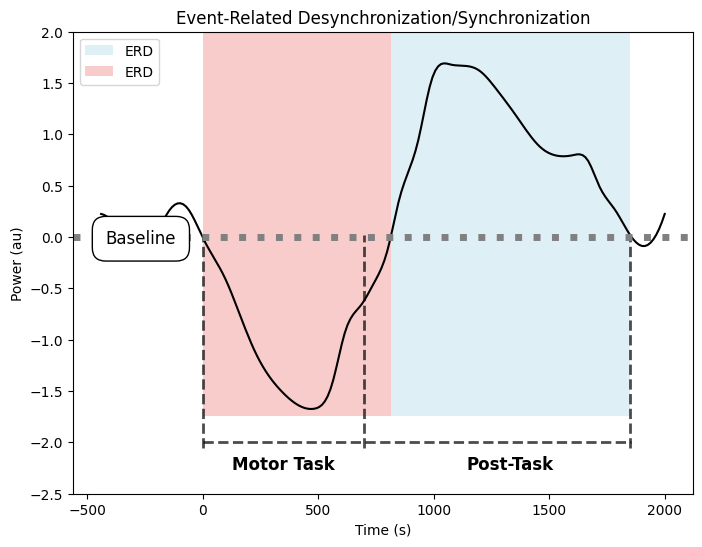

In [1175]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
data = np.loadtxt("interpolated_signal.csv", delimiter=",", skiprows=1)  # Omite el encabezado

# Separar las columnas X e Y
x_data = data[:, 0]  # Primera columna (X)
y_data = data[:, 1]  # Segunda columna (Y)

# Graficar los datos
plt.figure(figsize=(8, 6))
t = np.linspace(-440,2000,len(x_data))
plt.plot(t, y_data, color="black")
# Fondo entre x=3 y x=7
#plt.axvspan(0, 814, facecolor='red', alpha=0.2, label='ERD')
#plt.axvspan(814, 1850, facecolor='cyan', alpha=0.3, label='ERD')

plt.axvspan(814, 1850, 
           ymin=np.interp(-0.9, [-2.1, 5], [0, 1]),  # Convierte a coordenadas normalizadas
           ymax=np.interp(0.9, [-8, 0.9], [0, 1]),
           facecolor='lightblue',
           alpha=0.4,
           label='ERD')

plt.axvspan(0, 814, 
           ymin=np.interp(-0.9, [-2.1, 5], [0, 1]),  # Convierte a coordenadas normalizadas
           ymax=np.interp(0.9, [-8, 0.9], [0, 1]),
           facecolor='lightcoral',
           alpha=0.4,
           label='ERD')

plt.text(x=(0 + 700)/2,  # Centro horizontal
         y=-2.3,                     # Posición vertical
         s='Motor Task',                     # Texto
         ha='center',                 # Alineación horizontal
         va='bottom',                 # Alineación vertical
         fontsize=12,
         color='black',
         fontweight='bold')
plt.text(x=(1850 + 814)/2,  # Centro horizontal
         y=-2.3,                     # Posición vertical
         s='Post-Task',                     # Texto
         ha='center',                 # Alineación horizontal
         va='bottom',                 # Alineación vertical
         fontsize=12,
         color='black',
         fontweight='bold')

# plt.text(x=(-600 + 0)/2,  # Centro horizontal
#          y=0,                     # Posición vertical
#          s='Baseline',                     # Texto
#          ha='center',                 # Alineación horizontal
#          va='bottom',                 # Alineación vertical
#          fontsize=12,
#          color='black',
#          fontweight='bold')

# 3. Añadir líneas verticales para marcar el ancho
#plt.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)

plt.axvline(0, 
            ymin=0.1,  # Inicio (30% del eje Y)
            ymax=0.56,  # Fin (70% del eje Y)
            color='black', 
            linestyle='--', 
            linewidth=2, 
            alpha=0.7)

#plt.axvline(700, color='black', linestyle='--', linewidth=2, alpha=0.7)

plt.axvline(700, 
            ymin=0.1,  # Inicio (30% del eje Y)
            ymax=0.56,  # Fin (70% del eje Y)
            color='black', 
            linestyle='--', 
            linewidth=2, 
            alpha=0.7)

#plt.axvline(883, color='blue', linestyle='--', linewidth=1, alpha=0.7)
#plt.axvline(1850, color='black', linestyle='--', linewidth=2, alpha=0.7)

plt.axvline(1850, 
            ymin=0.1,  # Inicio (30% del eje Y)
            ymax=0.56,  # Fin (70% del eje Y)
            color='black', 
            linestyle='--', 
            linewidth=2, 
            alpha=0.7)

# Añadir cuadro de texto arriba de la gráfica
texto = "Baseline"
plt.figtext(0.21,                   # Posición horizontal (0-1, 0.5 = centro)
            0.55,                  # Posición vertical (0-1, 0.95 = arriba)
            texto, 
            ha='center',           # Alineación horizontal
            va='top',              # Alineación vertical
            fontsize=12, 
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white', alpha=1, edgecolor='black'))

# 4. Añadir línea horizontal de referencia
plt.axhline(0, color='gray', linestyle=':', linewidth=5)
plt.axhline(-2, 
            xmin=0.21,   # Inicio (20% del eje X)
            xmax=0.9,   # Fin (80% del eje X)
            color='black', 
            linestyle='--', 
            linewidth=2,
            alpha=0.7)


plt.ylim(-2.5, 2)

#plt.scatter(x_data, y_data, color="red", label="Puntos de Interpolación", s=10)  # Puntos
plt.xlabel("Time (s)")
plt.ylabel("Power (au)")
plt.title("Event-Related Desynchronization/Synchronization")
plt.legend()
#plt.grid(True)
plt.savefig('grafica_erd_ers.svg', format='svg')
plt.show()


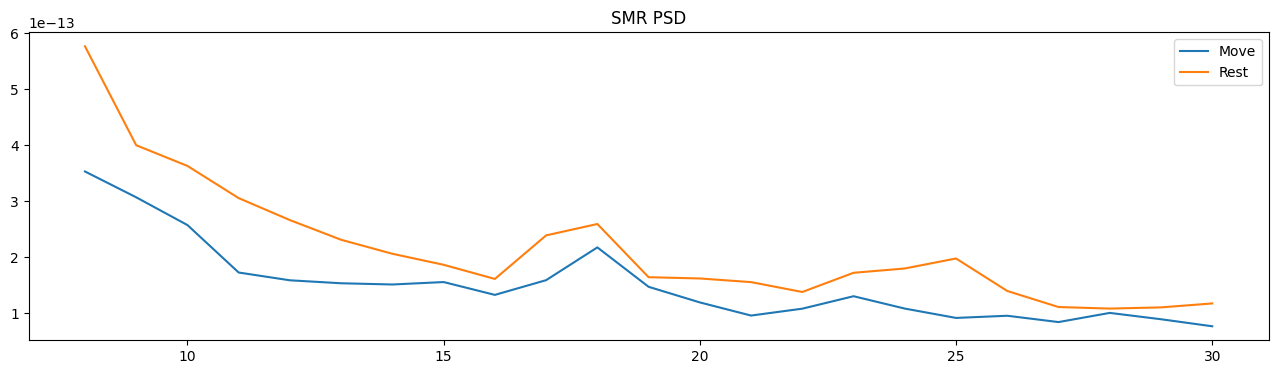

In [1176]:
PSD_move, freq = PSD_rithms(laplace_move)
PSD_rest, freq = PSD_rithms(laplace_rest)

plt.figure(figsize=(16, 4))
plt.plot(freq, np.mean(PSD_move, axis=0), label='Move')
plt.plot(freq, np.mean(PSD_rest, axis=0), label='Rest')
plt.legend()
plt.title('SMR PSD')
plt.show()

Accuracy promedio: 0.5000
Precision promedio: 0.2500
Recall promedio: 0.5000
F1-score promedio: 0.3333


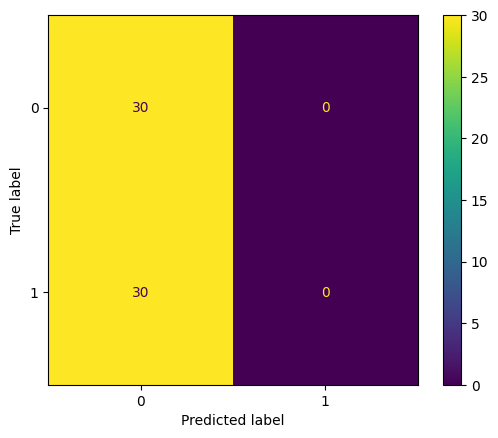

In [1177]:
X_test = np.concatenate((PSD_move,PSD_rest), axis=0)
y_test = np.concatenate((np.ones(len(PSD_move)),(np.zeros(len(PSD_rest)))), axis=0)
y_pred = lda.predict(X_test)


# Calcular métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy promedio: {acc:.4f}')
print(f'Precision promedio: {prec:.4f}')
print(f'Recall promedio: {rec:.4f}')
print(f'F1-score promedio: {f1:.4f}')


cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()

#### Tarea 3

In [1178]:
X_T3 = dictionary[ini+str(volunteer)]['Lower']['Task3']['X']
Y_T3 = dictionary[ini+str(volunteer)]['Lower']['Task3']['Y']

(30, 5, 1000)


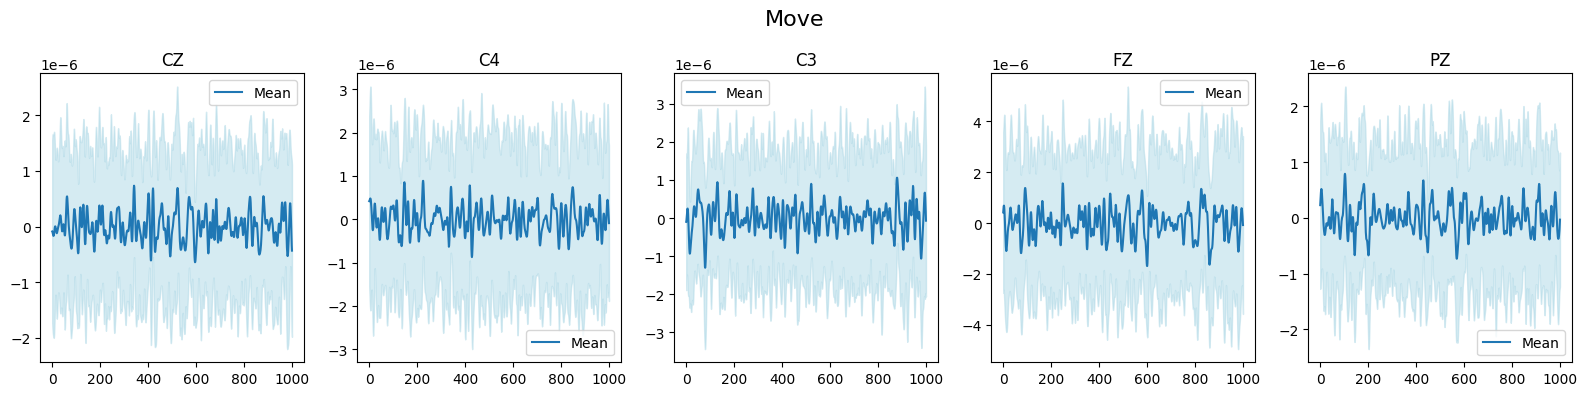

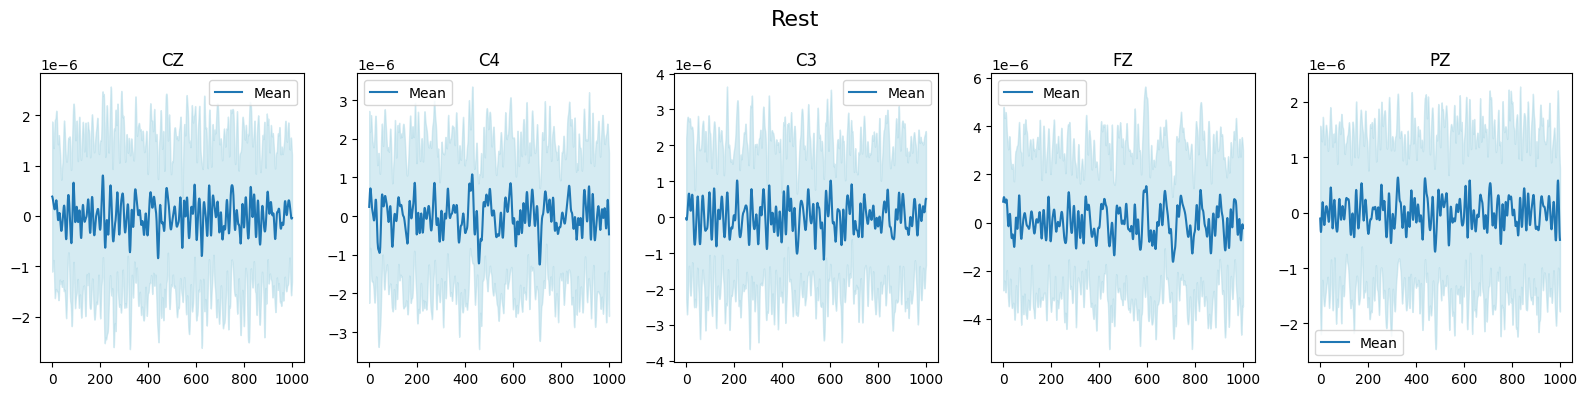

In [1179]:
print((X_T3['Move'].shape))
graph_mean_feet(X_T3['Move'],feet_channels,'Move')
graph_mean_feet(X_T3['Rest'],feet_channels,'Rest')

In [1180]:
laplace_move = laplacian_filter(X_T3['Move'])
trials, samples = laplace_move.shape
print(f"Move Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X_T3['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Move Trials=30|Samples=1000
Rest Trials=30|Samples=1000


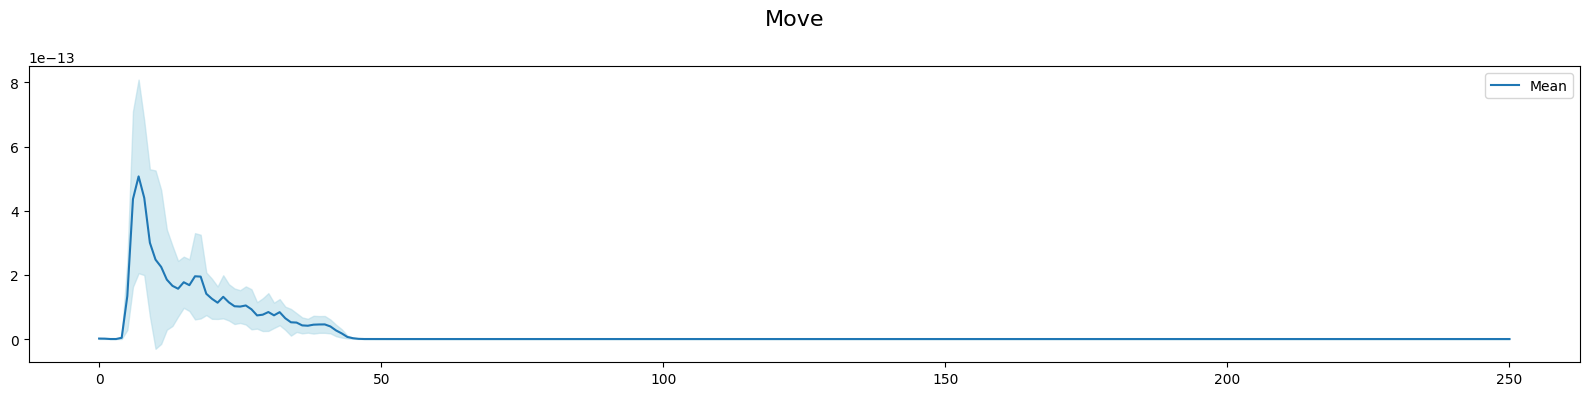

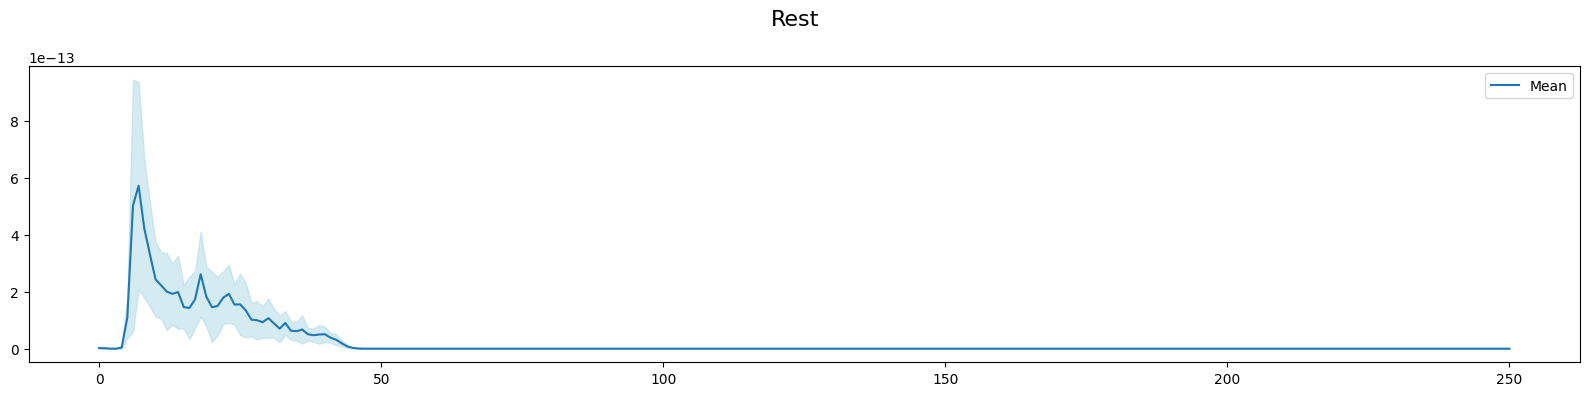

In [1181]:
PSD_move, freq = PSD(laplace_move)
PSD_rest, freq = PSD(laplace_rest)

graph_signals(PSD_move,'Move',freq)
graph_signals(PSD_rest,'Rest',freq)

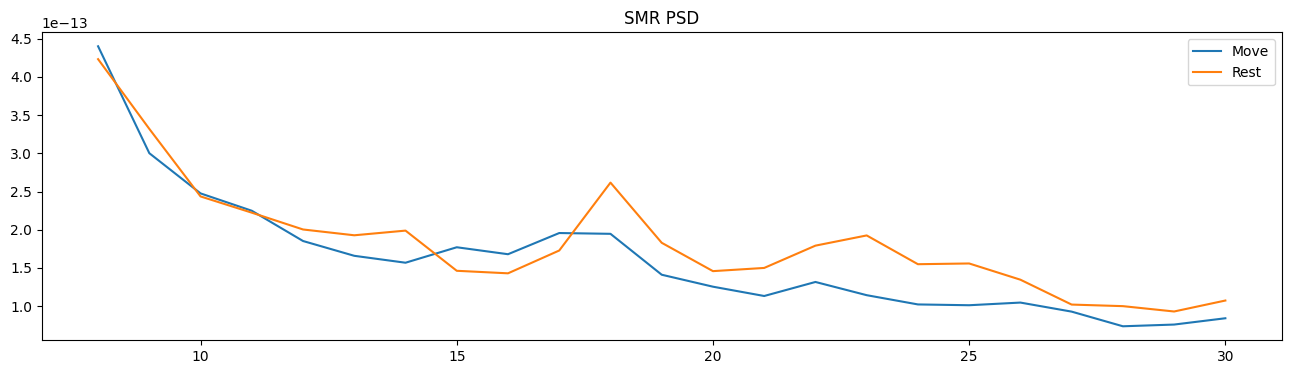

In [1182]:
PSD_move, freq = PSD_rithms(laplace_move)
PSD_rest, freq = PSD_rithms(laplace_rest)

plt.figure(figsize=(16, 4))
plt.plot(freq, np.mean(PSD_move, axis=0), label='Move')
plt.plot(freq, np.mean(PSD_rest, axis=0), label='Rest')
plt.legend()
plt.title('SMR PSD')
plt.show()



Accuracy promedio: 0.5000
Precision promedio: 0.2500
Recall promedio: 0.5000
F1-score promedio: 0.3333


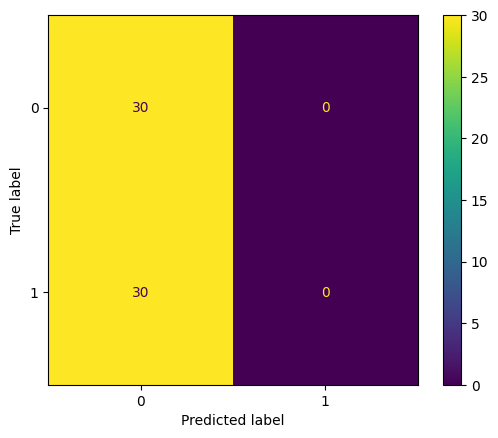

In [1183]:
X_test = np.concatenate((PSD_move,PSD_rest), axis=0)
y_test = np.concatenate((np.ones(len(PSD_move)),(np.zeros(len(PSD_rest)))), axis=0)
y_pred = lda.predict(X_test)


# Calcular métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy promedio: {acc:.4f}')
print(f'Precision promedio: {prec:.4f}')
print(f'Recall promedio: {rec:.4f}')
print(f'F1-score promedio: {f1:.4f}')


cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()